## Import Libraries/Dependencies

In [1]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
Image.MAX_IMAGE_PIXELS = 1000000000

## Define Training, Validation, and Testing Functions

In [2]:
# define functions for training (fine-tuning) and testing model
        
def finetune_ViT(model, trainloader, validationloader, optimizer, criterion, num_epochs, scheduler=None):
    
    m = nn.Sigmoid()
    tuning_parameters = [parameter for parameter in model.parameters() if parameter.requires_grad]
    
    avg_val_losses = []
    avg_training_losses = []
    epochs_finished = []
    
    # conditions for early stopping
    last_val_loss = float('inf')
    min_val_loss = float('inf')
    patience = 3
    es_counter = 0
    
    print("Starting training...")
    
    for epoch in range(num_epochs):
        
        model.train()
        if scheduler != None:
            print("Learning rate: ", scheduler.get_last_lr())
        
        running_loss = 0
        curr_total_train_loss = 0
        
        for i, data in enumerate(tqdm(trainloader, total=len(trainloader)), start=0):
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = m(outputs)
            
            loss = criterion(outputs, labels)
            curr_total_train_loss += loss.item()
            loss.backward()
            
            # perform grad clipping at global norm 1, as in ViT paper
            nn.utils.clip_grad_norm_(tuning_parameters, max_norm = 1)
            optimizer.step()
            
            # print statistics and current decayed learning rate
            running_loss += loss.item()
            if i % 20 == 19:    # print every 20 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 20))
                running_loss = 0.0
        
        epochs_finished.append(epoch+1)
        avg_training_losses.append(curr_total_train_loss/len(trainloader))
        
        # step scheduler after every epoch        
        if scheduler != None:
            scheduler.step()
        
        # check for changes in total validation loss to determine if early stopping is needed
        print("Checking validation loss...")
        curr_val_loss = loss_validation(model, validationloader, criterion)
        avg_val_losses.append(curr_val_loss)
        print("Average validation loss after last epoch: ", curr_val_loss)
        
        if curr_val_loss > last_val_loss:
            es_counter += 1
            
            if es_counter >= patience:
                print("Early stopping triggered. Ending training..")
                
                # plot training and validation losses
                plt.plot(epochs_finished, avg_training_losses, label = "Training Loss")
                plt.plot(epochs_finished, avg_val_losses, label = "Validation Loss")
                plt.title("ViT Training and Validation Loss")
                plt.ylabel("Loss")
                plt.xlabel("Epoch")
                plt.legend()
                return
            else:
                print(f"Increase in validation loss! {patience-es_counter} more consecutive loss increase(s) until early stop.")
        
        else:
            print("Decrease in validation loss. Early stop counter reset to 0.")
            es_counter = 0
            
        last_val_loss = curr_val_loss
        
        # check to save model if validation loss is lower than min recorded validation loss
        if curr_val_loss < min_val_loss:
            print("New best validation loss - saving model.")
            min_val_loss = curr_val_loss
            save_dir = "/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/ViT_19_layers_Tr_aug.pth"
            torch.save(model.state_dict(), save_dir)
    
    # plot training and validation losses
    plt.plot(epochs_finished, avg_training_losses, label = "Training Loss")
    plt.plot(epochs_finished, avg_val_losses, label = "Validation Loss")
    plt.title("ViT Training and Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

def test_ViT(model, testloader):
    model.eval()
    top1_correct = 0
    top3_correct = 0
    top5_correct = 0
    total = 0
    
    m = nn.Sigmoid()
    
    with torch.no_grad():
        for data in testloader:
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = our_ViT(images)
            probabilities = m(outputs)
            
            # calculate top-1 accuracy
            _, top1_predicted = torch.topk(probabilities, k=1, dim=1, sorted=False)
            for i, group in enumerate(top1_predicted):
                if labels[i] in group:
                    top1_correct += 1
            
            # calculate top-3 accuracy
            _, top3_predicted = torch.topk(probabilities, k=3, dim=1, sorted=False)
            for i, group in enumerate(top3_predicted):
                if labels[i] in group:
                    top3_correct += 1
            
            # calculate top-5 accuracy
            _, top5_predicted = torch.topk(probabilities, k=5, dim=1, sorted=False)
            for i, group in enumerate(top5_predicted):
                if labels[i] in group:
                    top5_correct += 1
            
            total += labels.size(0)
            
    top1_acc = top1_correct/total * 100
    top3_acc = top3_correct/total * 100
    top5_acc = top5_correct/total * 100
        
    return top1_acc, top3_acc, top5_acc

def loss_validation(model, validationloader, criterion):
    model.eval()
    total_val_loss = 0
    
    m = nn.Sigmoid()
    
    with torch.no_grad():
        for data in validationloader:
            
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = our_ViT(images)
            outputs = m(outputs)
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss/len(validationloader)
    
    return avg_val_loss

In [3]:
def perform_hp_tuning(model, trainingset, validationset, lr_array, batchsize_array, criterion, num_epochs=1):

    accuracies = np.empty([len(lr_array), len(batchsize_array)])
    tuning_parameters = [parameter for parameter in model.parameters() if parameter.requires_grad]

    # run validation testing

    for i, lr in enumerate(lr_array):
        
        # reset optimizer with new learning rate
        optimizer = optim.SGD(tuning_parameters, lr=lr, momentum = .9)

        for j, batch_size in enumerate(batchsize_array):

            print("LEARNING RATE: ", lr)
            print("BATCH SIZE: ", batch_size)

            # restore original weights for ViT
            model.load_state_dict(torch.load("/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/untrained_ViT.pth"))

            # define data loaders for training and testing data
            trainloader = torch.utils.data.DataLoader(trainingset, batch_size=batch_size, num_workers=2)
            testloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, num_workers=2)
            
            # train ViT using current hps
            finetune_ViT(model, trainloader=trainloader, validationloader=testloader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs)

            # test performance on validation dataset
            result = test_ViT(model, testloader)

            accuracies[i,j] = result
            print(f"Accuracy for lr={lr} and bs={batch_size}: {accuracies[i,j]}\n")


    # choose learning rate and batch size with best validation accuracy
    print("---HP TESTING COMPLETE---")
    print("Accuracy Matrix: \n", accuracies)
    best_lr_ind, best_bs_ind = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)
    
    optimal_lr = learning_rates[best_lr_ind]
    optimal_batch_size = batchsize_array[best_bs_ind]

    print(f"\nBest learning rate: {optimal_lr}")
    print(f"Best batch size: {optimal_batch_size}")
    return optimal_lr, optimal_batch_size

## Model Initialization and Configuration

In [4]:
# create ViT for art style classification
our_ViT = timm.create_model('vit_huge_patch14_224_in21k', pretrained = True, num_classes = 25)

# confirm changes in classifier output
our_ViT.get_classifier()

Removing representation layer for fine-tuning.


Linear(in_features=1280, out_features=25, bias=True)

In [5]:
# basic pre-processing tasks for proper ViT data ingestion
config = resolve_data_config({}, model=our_ViT)
transform = create_transform(**config)

In [6]:
# move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# save starting state for ViT
torch.save(our_ViT.state_dict(), "/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/untrained_ViT.pth")

our_ViT.to(device)

Device: cuda:0


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm

## Layer Freezing

In [7]:
def ViT_layer_freeze(model):

    layer_count = 0

    print("All Model Layers: \n")
    for layer_name_1, module in list(model.named_children()):

        if isinstance(module, nn.Sequential):
            for layer_name_2, block in list(module.named_children()):
                layer_count += 1
                print(layer_count,": Block",layer_name_2)
        else:
            layer_count += 1
            print(layer_count,":",layer_name_1)

    num_to_tune = int(input("How many layers would you like to finetune (top down)?: "))
    
    while not (num_to_tune <= layer_count and num_to_tune > 0):
        print("Invalid entry. Try again.")
        num_to_tune = int(input("How many layers would you like to finetune (top down)?: "))

    # begin freezing layers
    num_to_freeze = layer_count-num_to_tune
    layers_frozen = 0
    unfrozen_layers = []

    # handle cls_token and pos_embed parameters, which are not contained within model children
    cls_token = list(model.parameters())[0]
    pos_embed = list(model.parameters())[1]

    if num_to_freeze == 0:
        cls_token.requires_grad = True
        unfrozen_layers.append("cls_token")
        pos_embed.requires_grad = True
        unfrozen_layers.append("pos_embed")
    else:
        cls_token.requires_grad = False
        pos_embed.requires_grad = False

    for layer_name_1, module in list(model.named_children()):

        if isinstance(module, nn.Sequential):
            for layer_name_2, block in list(module.named_children()):
                if layers_frozen < num_to_freeze:
                    # freeze all parameters in the layer
                    for param in block.parameters():
                        param.requires_grad = False
                    layers_frozen += 1
                else:
                    unfrozen_layers.append("Block " + layer_name_2)
                    for param in block.parameters():
                        param.requires_grad = True
        else:
            if layers_frozen < num_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False
                layers_frozen += 1
            else:
                unfrozen_layers.append(layer_name_1)
                for param in module.parameters():
                    param.requires_grad = True

    if num_to_freeze == 0:
        print("\nAll layers are unfrozen.")
    else:
        print("\nFreezing complete. The following layers will be finetuned: ")
        for name in unfrozen_layers:
            print(name)

In [8]:
# execute layer freezing
ViT_layer_freeze(our_ViT)

All Model Layers: 

1 : patch_embed
2 : pos_drop
3 : Block 0
4 : Block 1
5 : Block 2
6 : Block 3
7 : Block 4
8 : Block 5
9 : Block 6
10 : Block 7
11 : Block 8
12 : Block 9
13 : Block 10
14 : Block 11
15 : Block 12
16 : Block 13
17 : Block 14
18 : Block 15
19 : Block 16
20 : Block 17
21 : Block 18
22 : Block 19
23 : Block 20
24 : Block 21
25 : Block 22
26 : Block 23
27 : Block 24
28 : Block 25
29 : Block 26
30 : Block 27
31 : Block 28
32 : Block 29
33 : Block 30
34 : Block 31
35 : norm
36 : pre_logits
37 : head
How many layers would you like to finetune (top down)?: 19

Freezing complete. The following layers will be finetuned: 
Block 16
Block 17
Block 18
Block 19
Block 20
Block 21
Block 22
Block 23
Block 24
Block 25
Block 26
Block 27
Block 28
Block 29
Block 30
Block 31
norm
pre_logits
head


In [9]:
# check that correct parameters are frozen
for name, param in our_ViT.named_parameters():
    if param.requires_grad:
        print(name)

blocks.16.norm1.weight
blocks.16.norm1.bias
blocks.16.attn.qkv.weight
blocks.16.attn.qkv.bias
blocks.16.attn.proj.weight
blocks.16.attn.proj.bias
blocks.16.norm2.weight
blocks.16.norm2.bias
blocks.16.mlp.fc1.weight
blocks.16.mlp.fc1.bias
blocks.16.mlp.fc2.weight
blocks.16.mlp.fc2.bias
blocks.17.norm1.weight
blocks.17.norm1.bias
blocks.17.attn.qkv.weight
blocks.17.attn.qkv.bias
blocks.17.attn.proj.weight
blocks.17.attn.proj.bias
blocks.17.norm2.weight
blocks.17.norm2.bias
blocks.17.mlp.fc1.weight
blocks.17.mlp.fc1.bias
blocks.17.mlp.fc2.weight
blocks.17.mlp.fc2.bias
blocks.18.norm1.weight
blocks.18.norm1.bias
blocks.18.attn.qkv.weight
blocks.18.attn.qkv.bias
blocks.18.attn.proj.weight
blocks.18.attn.proj.bias
blocks.18.norm2.weight
blocks.18.norm2.bias
blocks.18.mlp.fc1.weight
blocks.18.mlp.fc1.bias
blocks.18.mlp.fc2.weight
blocks.18.mlp.fc2.bias
blocks.19.norm1.weight
blocks.19.norm1.bias
blocks.19.attn.qkv.weight
blocks.19.attn.qkv.bias
blocks.19.attn.proj.weight
blocks.19.attn.proj.b

## Data Preparation and Validation Testing for Hyperparameter Tuning

In [10]:
# initialize training dataset

trainpath = "/projectnb/dl523/projects/Sarcasm/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full_aug/train"
#trainpath = "/projectnb/dl523/students/kjv/EC520_Project/Data/wikipaintings_small/wikipaintings_train"
trainset = datasets.ImageFolder(trainpath, transform=transform)

# initialize validation dataset

validationpath = "/projectnb/dl523/projects/Sarcasm/wikipaintings_full/wikipaintings_val"
validationset = datasets.ImageFolder(validationpath, transform=transform)

# initialize test dataset

testpath = "/projectnb/dl523/projects/Sarcasm/wikipaintings_full/wikipaintings_test"
testset = datasets.ImageFolder(testpath, transform=transform)

In [ ]:
# perform validation testing for optimal hyperparameter determination

criterion = nn.CrossEntropyLoss()
learning_rates = [0.003, 0.01, 0.03, 0.06] # from ViT paper
batch_sizes = [32, 64, 128, 256, 512]

optimal_lr, optimal_batch_size = perform_hp_tuning(model=our_ViT, trainingset=trainset, validationset=validationset, lr_array=learning_rates, batchsize_array=batch_sizes, criterion=criterion)
# validation testing produced optimal_lr = 0.06 and optimal_batch_size = 128

In [11]:
# initialize dataloaders using optimal batch size

optimal_batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=optimal_batch_size, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=optimal_batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=optimal_batch_size, shuffle=True, num_workers=2)

## Pre-training Visualizations

torch.Size([16, 3, 224, 224])
Class:  tensor([12, 21, 18,  9, 21,  9,  0, 10,  6,  1,  2, 18, 19,  3, 12,  6])


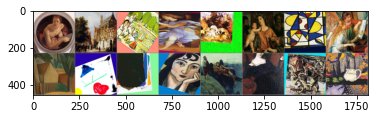

In [12]:
# get random training images to verify import worked
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

# show images
def imshow(img):
    img = img * our_ViT.default_cfg['std'][0] + our_ViT.default_cfg['mean'][0]  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

# show labels
print("Class: ", labels)

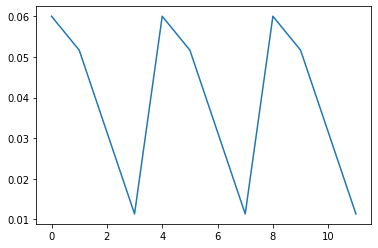

In [13]:
# set optimizer to use optimal learning rate
tuning_parameters = [parameter for parameter in our_ViT.parameters() if parameter.requires_grad]
optimal_lr = 0.06
optimizer = optim.SGD(tuning_parameters, lr=optimal_lr, momentum = .9)

# initialize scheduler to implement cosine learning rate decay during training
# Note: choose values for T_0 and num_epochs based on desired number of restarts during training
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, eta_min=0.003)

# visualize scheduler learning rate decay to occur during training based on num_epochs
lrs = []
num_epochs = 12

for epoch in range(num_epochs):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

lrs = np.array(lrs)
plt.plot(lrs)

## Train the ViT

In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 12

# reset optimizer and scheduler
optimizer = optim.SGD(tuning_parameters, lr=optimal_lr, momentum = .9)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=4, eta_min=0.003)

# train the ViT using set optimizer and scheduler
finetune_ViT(our_ViT, trainloader=trainloader, validationloader=validationloader, optimizer=optimizer, criterion=criterion, num_epochs=num_epochs, scheduler=scheduler)

Starting training...
Learning rate:  [0.06]


  0%|          | 0/15397 [00:00<?, ?it/s]

[1,    20] loss: 3.214
[1,    40] loss: 3.204
[1,    60] loss: 3.187
[1,    80] loss: 3.169
[1,   100] loss: 3.141
[1,   120] loss: 3.119
[1,   140] loss: 3.075
[1,   160] loss: 3.026
[1,   180] loss: 3.002
[1,   200] loss: 2.955
[1,   220] loss: 2.947
[1,   240] loss: 2.932
[1,   260] loss: 2.892
[1,   280] loss: 2.896
[1,   300] loss: 2.883
[1,   320] loss: 2.870
[1,   340] loss: 2.883
[1,   360] loss: 2.847
[1,   380] loss: 2.843
[1,   400] loss: 2.814
[1,   420] loss: 2.812
[1,   440] loss: 2.819
[1,   460] loss: 2.807
[1,   480] loss: 2.782
[1,   500] loss: 2.808
[1,   520] loss: 2.788
[1,   540] loss: 2.795
[1,   560] loss: 2.784
[1,   580] loss: 2.795
[1,   600] loss: 2.771
[1,   620] loss: 2.758
[1,   640] loss: 2.804
[1,   660] loss: 2.759
[1,   680] loss: 2.775
[1,   700] loss: 2.753
[1,   720] loss: 2.733
[1,   740] loss: 2.760
[1,   760] loss: 2.727
[1,   780] loss: 2.748
[1,   800] loss: 2.740
[1,   820] loss: 2.715
[1,   840] loss: 2.743
[1,   860] loss: 2.772
[1,   880] 

[1,  7160] loss: 2.583
[1,  7180] loss: 2.563
[1,  7200] loss: 2.605
[1,  7220] loss: 2.554
[1,  7240] loss: 2.597
[1,  7260] loss: 2.593
[1,  7280] loss: 2.577
[1,  7300] loss: 2.588
[1,  7320] loss: 2.622
[1,  7340] loss: 2.596
[1,  7360] loss: 2.557
[1,  7380] loss: 2.574
[1,  7400] loss: 2.570
[1,  7420] loss: 2.577
[1,  7440] loss: 2.595
[1,  7460] loss: 2.614
[1,  7480] loss: 2.567
[1,  7500] loss: 2.588
[1,  7520] loss: 2.591
[1,  7540] loss: 2.550
[1,  7560] loss: 2.575
[1,  7580] loss: 2.572
[1,  7600] loss: 2.584
[1,  7620] loss: 2.598
[1,  7640] loss: 2.577
[1,  7660] loss: 2.591
[1,  7680] loss: 2.547
[1,  7700] loss: 2.615
[1,  7720] loss: 2.625
[1,  7740] loss: 2.552
[1,  7760] loss: 2.604
[1,  7780] loss: 2.582
[1,  7800] loss: 2.615
[1,  7820] loss: 2.579
[1,  7840] loss: 2.598
[1,  7860] loss: 2.585
[1,  7880] loss: 2.589
[1,  7900] loss: 2.605
[1,  7920] loss: 2.613
[1,  7940] loss: 2.597
[1,  7960] loss: 2.580
[1,  7980] loss: 2.573
[1,  8000] loss: 2.578
[1,  8020] 

[1, 14300] loss: 2.527
[1, 14320] loss: 2.556
[1, 14340] loss: 2.564
[1, 14360] loss: 2.545
[1, 14380] loss: 2.584
[1, 14400] loss: 2.530
[1, 14420] loss: 2.541
[1, 14440] loss: 2.519
[1, 14460] loss: 2.529
[1, 14480] loss: 2.556
[1, 14500] loss: 2.549
[1, 14520] loss: 2.549
[1, 14540] loss: 2.551
[1, 14560] loss: 2.559
[1, 14580] loss: 2.545
[1, 14600] loss: 2.529
[1, 14620] loss: 2.565
[1, 14640] loss: 2.539
[1, 14660] loss: 2.560
[1, 14680] loss: 2.572
[1, 14700] loss: 2.576
[1, 14720] loss: 2.555
[1, 14740] loss: 2.545
[1, 14760] loss: 2.553
[1, 14780] loss: 2.531
[1, 14800] loss: 2.513
[1, 14820] loss: 2.572
[1, 14840] loss: 2.536
[1, 14860] loss: 2.579
[1, 14880] loss: 2.527
[1, 14900] loss: 2.529
[1, 14920] loss: 2.537
[1, 14940] loss: 2.513
[1, 14960] loss: 2.526
[1, 14980] loss: 2.506
[1, 15000] loss: 2.554
[1, 15020] loss: 2.526
[1, 15040] loss: 2.562
[1, 15060] loss: 2.572
[1, 15080] loss: 2.533
[1, 15100] loss: 2.507
[1, 15120] loss: 2.554
[1, 15140] loss: 2.541
[1, 15160] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[2,    20] loss: 2.506
[2,    40] loss: 2.542
[2,    60] loss: 2.515
[2,    80] loss: 2.502
[2,   100] loss: 2.524
[2,   120] loss: 2.514
[2,   140] loss: 2.524
[2,   160] loss: 2.512
[2,   180] loss: 2.518
[2,   200] loss: 2.500
[2,   220] loss: 2.489
[2,   240] loss: 2.514
[2,   260] loss: 2.521
[2,   280] loss: 2.528
[2,   300] loss: 2.498
[2,   320] loss: 2.522
[2,   340] loss: 2.510
[2,   360] loss: 2.532
[2,   380] loss: 2.489
[2,   400] loss: 2.492
[2,   420] loss: 2.523
[2,   440] loss: 2.533
[2,   460] loss: 2.513
[2,   480] loss: 2.491
[2,   500] loss: 2.494
[2,   520] loss: 2.514
[2,   540] loss: 2.501
[2,   560] loss: 2.530
[2,   580] loss: 2.504
[2,   600] loss: 2.518
[2,   620] loss: 2.479
[2,   640] loss: 2.530
[2,   660] loss: 2.501
[2,   680] loss: 2.503
[2,   700] loss: 2.479
[2,   720] loss: 2.521
[2,   740] loss: 2.509
[2,   760] loss: 2.525
[2,   780] loss: 2.479
[2,   800] loss: 2.505
[2,   820] loss: 2.505
[2,   840] loss: 2.512
[2,   860] loss: 2.514
[2,   880] 

[2,  7160] loss: 2.522
[2,  7180] loss: 2.500
[2,  7200] loss: 2.499
[2,  7220] loss: 2.498
[2,  7240] loss: 2.506
[2,  7260] loss: 2.493
[2,  7280] loss: 2.496
[2,  7300] loss: 2.509
[2,  7320] loss: 2.517
[2,  7340] loss: 2.529
[2,  7360] loss: 2.479
[2,  7380] loss: 2.503
[2,  7400] loss: 2.474
[2,  7420] loss: 2.505
[2,  7440] loss: 2.483
[2,  7460] loss: 2.465
[2,  7480] loss: 2.493
[2,  7500] loss: 2.511
[2,  7520] loss: 2.483
[2,  7540] loss: 2.491
[2,  7560] loss: 2.500
[2,  7580] loss: 2.500
[2,  7600] loss: 2.512
[2,  7620] loss: 2.512
[2,  7640] loss: 2.497
[2,  7660] loss: 2.473
[2,  7680] loss: 2.474
[2,  7700] loss: 2.493
[2,  7720] loss: 2.488
[2,  7740] loss: 2.482
[2,  7760] loss: 2.507
[2,  7780] loss: 2.507
[2,  7800] loss: 2.514
[2,  7820] loss: 2.504
[2,  7840] loss: 2.464
[2,  7860] loss: 2.480
[2,  7880] loss: 2.494
[2,  7900] loss: 2.508
[2,  7920] loss: 2.509
[2,  7940] loss: 2.502
[2,  7960] loss: 2.499
[2,  7980] loss: 2.503
[2,  8000] loss: 2.499
[2,  8020] 

[2, 14300] loss: 2.501
[2, 14320] loss: 2.474
[2, 14340] loss: 2.472
[2, 14360] loss: 2.473
[2, 14380] loss: 2.451
[2, 14400] loss: 2.469
[2, 14420] loss: 2.472
[2, 14440] loss: 2.478
[2, 14460] loss: 2.461
[2, 14480] loss: 2.493
[2, 14500] loss: 2.494
[2, 14520] loss: 2.469
[2, 14540] loss: 2.463
[2, 14560] loss: 2.487
[2, 14580] loss: 2.455
[2, 14600] loss: 2.504
[2, 14620] loss: 2.465
[2, 14640] loss: 2.480
[2, 14660] loss: 2.484
[2, 14680] loss: 2.494
[2, 14700] loss: 2.478
[2, 14720] loss: 2.491
[2, 14740] loss: 2.464
[2, 14760] loss: 2.487
[2, 14780] loss: 2.453
[2, 14800] loss: 2.479
[2, 14820] loss: 2.491
[2, 14840] loss: 2.481
[2, 14860] loss: 2.468
[2, 14880] loss: 2.467
[2, 14900] loss: 2.487
[2, 14920] loss: 2.499
[2, 14940] loss: 2.502
[2, 14960] loss: 2.462
[2, 14980] loss: 2.462
[2, 15000] loss: 2.501
[2, 15020] loss: 2.499
[2, 15040] loss: 2.492
[2, 15060] loss: 2.455
[2, 15080] loss: 2.464
[2, 15100] loss: 2.480
[2, 15120] loss: 2.469
[2, 15140] loss: 2.467
[2, 15160] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[3,    20] loss: 2.450
[3,    40] loss: 2.439
[3,    60] loss: 2.459
[3,    80] loss: 2.444
[3,   100] loss: 2.448
[3,   120] loss: 2.433
[3,   140] loss: 2.447
[3,   160] loss: 2.473
[3,   180] loss: 2.447
[3,   200] loss: 2.430
[3,   220] loss: 2.438
[3,   240] loss: 2.474
[3,   260] loss: 2.419
[3,   280] loss: 2.461
[3,   300] loss: 2.438
[3,   320] loss: 2.419
[3,   340] loss: 2.428
[3,   360] loss: 2.473
[3,   380] loss: 2.433
[3,   400] loss: 2.467
[3,   420] loss: 2.444
[3,   440] loss: 2.467
[3,   460] loss: 2.456
[3,   480] loss: 2.460
[3,   500] loss: 2.433
[3,   520] loss: 2.477
[3,   540] loss: 2.441
[3,   560] loss: 2.456
[3,   580] loss: 2.456
[3,   600] loss: 2.456
[3,   620] loss: 2.457
[3,   640] loss: 2.434
[3,   660] loss: 2.413
[3,   680] loss: 2.435
[3,   700] loss: 2.454
[3,   720] loss: 2.449
[3,   740] loss: 2.430
[3,   760] loss: 2.466
[3,   780] loss: 2.450
[3,   800] loss: 2.428
[3,   820] loss: 2.449
[3,   840] loss: 2.450
[3,   860] loss: 2.457
[3,   880] 

[3,  7160] loss: 2.441
[3,  7180] loss: 2.428
[3,  7200] loss: 2.437
[3,  7220] loss: 2.429
[3,  7240] loss: 2.433
[3,  7260] loss: 2.443
[3,  7280] loss: 2.459
[3,  7300] loss: 2.432
[3,  7320] loss: 2.419
[3,  7340] loss: 2.423
[3,  7360] loss: 2.458
[3,  7380] loss: 2.457
[3,  7400] loss: 2.437
[3,  7420] loss: 2.417
[3,  7440] loss: 2.422
[3,  7460] loss: 2.438
[3,  7480] loss: 2.429
[3,  7500] loss: 2.434
[3,  7520] loss: 2.428
[3,  7540] loss: 2.447
[3,  7560] loss: 2.463
[3,  7580] loss: 2.419
[3,  7600] loss: 2.436
[3,  7620] loss: 2.410
[3,  7640] loss: 2.417
[3,  7660] loss: 2.432
[3,  7680] loss: 2.428
[3,  7700] loss: 2.434
[3,  7720] loss: 2.450
[3,  7740] loss: 2.413
[3,  7760] loss: 2.434
[3,  7780] loss: 2.417
[3,  7800] loss: 2.423
[3,  7820] loss: 2.417
[3,  7840] loss: 2.444
[3,  7860] loss: 2.437
[3,  7880] loss: 2.445
[3,  7900] loss: 2.412
[3,  7920] loss: 2.441
[3,  7940] loss: 2.412
[3,  7960] loss: 2.409
[3,  7980] loss: 2.442
[3,  8000] loss: 2.442
[3,  8020] 

[3, 14300] loss: 2.412
[3, 14320] loss: 2.431
[3, 14340] loss: 2.437
[3, 14360] loss: 2.438
[3, 14380] loss: 2.429
[3, 14400] loss: 2.442
[3, 14420] loss: 2.401
[3, 14440] loss: 2.432
[3, 14460] loss: 2.426
[3, 14480] loss: 2.422
[3, 14500] loss: 2.423
[3, 14520] loss: 2.434
[3, 14540] loss: 2.445
[3, 14560] loss: 2.430
[3, 14580] loss: 2.431
[3, 14600] loss: 2.447
[3, 14620] loss: 2.461
[3, 14640] loss: 2.434
[3, 14660] loss: 2.433
[3, 14680] loss: 2.442
[3, 14700] loss: 2.407
[3, 14720] loss: 2.429
[3, 14740] loss: 2.447
[3, 14760] loss: 2.435
[3, 14780] loss: 2.411
[3, 14800] loss: 2.438
[3, 14820] loss: 2.433
[3, 14840] loss: 2.408
[3, 14860] loss: 2.396
[3, 14880] loss: 2.424
[3, 14900] loss: 2.447
[3, 14920] loss: 2.425
[3, 14940] loss: 2.414
[3, 14960] loss: 2.449
[3, 14980] loss: 2.405
[3, 15000] loss: 2.404
[3, 15020] loss: 2.433
[3, 15040] loss: 2.438
[3, 15060] loss: 2.399
[3, 15080] loss: 2.414
[3, 15100] loss: 2.426
[3, 15120] loss: 2.422
[3, 15140] loss: 2.435
[3, 15160] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[4,    20] loss: 2.425
[4,    40] loss: 2.413
[4,    60] loss: 2.369
[4,    80] loss: 2.398
[4,   100] loss: 2.391
[4,   120] loss: 2.406
[4,   140] loss: 2.396
[4,   160] loss: 2.388
[4,   180] loss: 2.383
[4,   200] loss: 2.426
[4,   220] loss: 2.406
[4,   240] loss: 2.400
[4,   260] loss: 2.406
[4,   280] loss: 2.384
[4,   300] loss: 2.395
[4,   320] loss: 2.397
[4,   340] loss: 2.403
[4,   360] loss: 2.398
[4,   380] loss: 2.424
[4,   400] loss: 2.419
[4,   420] loss: 2.411
[4,   440] loss: 2.393
[4,   460] loss: 2.393
[4,   480] loss: 2.394
[4,   500] loss: 2.397
[4,   520] loss: 2.393
[4,   540] loss: 2.414
[4,   560] loss: 2.410
[4,   580] loss: 2.410
[4,   600] loss: 2.365
[4,   620] loss: 2.392
[4,   640] loss: 2.405
[4,   660] loss: 2.406
[4,   680] loss: 2.395
[4,   700] loss: 2.393
[4,   720] loss: 2.385
[4,   740] loss: 2.372
[4,   760] loss: 2.388
[4,   780] loss: 2.398
[4,   800] loss: 2.423
[4,   820] loss: 2.393
[4,   840] loss: 2.389
[4,   860] loss: 2.402
[4,   880] 

[4,  7160] loss: 2.387
[4,  7180] loss: 2.419
[4,  7200] loss: 2.395
[4,  7220] loss: 2.379
[4,  7240] loss: 2.388
[4,  7260] loss: 2.403
[4,  7280] loss: 2.374
[4,  7300] loss: 2.375
[4,  7320] loss: 2.383
[4,  7340] loss: 2.376
[4,  7360] loss: 2.379
[4,  7380] loss: 2.391
[4,  7400] loss: 2.388
[4,  7420] loss: 2.395
[4,  7440] loss: 2.403
[4,  7460] loss: 2.386
[4,  7480] loss: 2.384
[4,  7500] loss: 2.388
[4,  7520] loss: 2.406
[4,  7540] loss: 2.390
[4,  7560] loss: 2.381
[4,  7580] loss: 2.398
[4,  7600] loss: 2.399
[4,  7620] loss: 2.404
[4,  7640] loss: 2.405
[4,  7660] loss: 2.402
[4,  7680] loss: 2.387
[4,  7700] loss: 2.390
[4,  7720] loss: 2.378
[4,  7740] loss: 2.364
[4,  7760] loss: 2.382
[4,  7780] loss: 2.395
[4,  7800] loss: 2.402
[4,  7820] loss: 2.383
[4,  7840] loss: 2.379
[4,  7860] loss: 2.396
[4,  7880] loss: 2.397
[4,  7900] loss: 2.382
[4,  7920] loss: 2.392
[4,  7940] loss: 2.388
[4,  7960] loss: 2.402
[4,  7980] loss: 2.395
[4,  8000] loss: 2.393
[4,  8020] 

[4, 14400] loss: 2.393
[4, 14420] loss: 2.397
[4, 14440] loss: 2.399
[4, 14460] loss: 2.424
[4, 14480] loss: 2.404
[4, 14500] loss: 2.371
[4, 14520] loss: 2.428
[4, 14540] loss: 2.374
[4, 14560] loss: 2.364
[4, 14580] loss: 2.419
[4, 14600] loss: 2.405
[4, 14620] loss: 2.376
[4, 14640] loss: 2.388
[4, 14660] loss: 2.399
[4, 14680] loss: 2.370
[4, 14700] loss: 2.400
[4, 14720] loss: 2.377
[4, 14740] loss: 2.408
[4, 14760] loss: 2.392
[4, 14780] loss: 2.424
[4, 14800] loss: 2.393
[4, 14820] loss: 2.400
[4, 14840] loss: 2.397
[4, 14860] loss: 2.369
[4, 14880] loss: 2.386
[4, 14900] loss: 2.391
[4, 14920] loss: 2.401
[4, 14940] loss: 2.389
[4, 14960] loss: 2.391
[4, 14980] loss: 2.379
[4, 15000] loss: 2.405
[4, 15020] loss: 2.380
[4, 15040] loss: 2.384
[4, 15060] loss: 2.378
[4, 15080] loss: 2.381
[4, 15100] loss: 2.411
[4, 15120] loss: 2.396
[4, 15140] loss: 2.415
[4, 15160] loss: 2.385
[4, 15180] loss: 2.384
[4, 15200] loss: 2.404
[4, 15220] loss: 2.366
[4, 15240] loss: 2.397
[4, 15260] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[5,    20] loss: 2.377
[5,    40] loss: 2.376
[5,    60] loss: 2.421
[5,    80] loss: 2.375
[5,   100] loss: 2.389
[5,   120] loss: 2.371
[5,   140] loss: 2.370
[5,   160] loss: 2.418
[5,   180] loss: 2.395
[5,   200] loss: 2.380
[5,   220] loss: 2.368
[5,   240] loss: 2.398
[5,   260] loss: 2.407
[5,   280] loss: 2.419
[5,   300] loss: 2.378
[5,   320] loss: 2.389
[5,   340] loss: 2.384
[5,   360] loss: 2.395
[5,   380] loss: 2.409
[5,   400] loss: 2.390
[5,   420] loss: 2.398
[5,   440] loss: 2.395
[5,   460] loss: 2.374
[5,   480] loss: 2.362
[5,   500] loss: 2.397
[5,   520] loss: 2.395
[5,   540] loss: 2.416
[5,   560] loss: 2.399
[5,   580] loss: 2.385
[5,   600] loss: 2.371
[5,   620] loss: 2.382
[5,   640] loss: 2.374
[5,   660] loss: 2.383
[5,   680] loss: 2.377
[5,   700] loss: 2.404
[5,   720] loss: 2.368
[5,   740] loss: 2.385
[5,   760] loss: 2.403
[5,   780] loss: 2.400
[5,   800] loss: 2.387
[5,   820] loss: 2.389
[5,   840] loss: 2.400
[5,   860] loss: 2.392
[5,   880] 

[5,  7160] loss: 2.414
[5,  7180] loss: 2.424
[5,  7200] loss: 2.409
[5,  7220] loss: 2.402
[5,  7240] loss: 2.403
[5,  7260] loss: 2.399
[5,  7280] loss: 2.401
[5,  7300] loss: 2.426
[5,  7320] loss: 2.411
[5,  7340] loss: 2.412
[5,  7360] loss: 2.446
[5,  7380] loss: 2.403
[5,  7400] loss: 2.431
[5,  7420] loss: 2.407
[5,  7440] loss: 2.397
[5,  7460] loss: 2.411
[5,  7480] loss: 2.410
[5,  7500] loss: 2.406
[5,  7520] loss: 2.415
[5,  7540] loss: 2.427
[5,  7560] loss: 2.407
[5,  7580] loss: 2.415
[5,  7600] loss: 2.411
[5,  7620] loss: 2.408
[5,  7640] loss: 2.406
[5,  7660] loss: 2.420
[5,  7680] loss: 2.401
[5,  7700] loss: 2.393
[5,  7720] loss: 2.437
[5,  7740] loss: 2.409
[5,  7760] loss: 2.404
[5,  7780] loss: 2.414
[5,  7800] loss: 2.393
[5,  7820] loss: 2.386
[5,  7840] loss: 2.389
[5,  7860] loss: 2.411
[5,  7880] loss: 2.461
[5,  7900] loss: 2.418
[5,  7920] loss: 2.427
[5,  7940] loss: 2.403
[5,  7960] loss: 2.426
[5,  7980] loss: 2.403
[5,  8000] loss: 2.393
[5,  8020] 

[5, 14300] loss: 2.401
[5, 14320] loss: 2.434
[5, 14340] loss: 2.390
[5, 14360] loss: 2.436
[5, 14380] loss: 2.424
[5, 14400] loss: 2.415
[5, 14420] loss: 2.397
[5, 14440] loss: 2.429
[5, 14460] loss: 2.420
[5, 14480] loss: 2.427
[5, 14500] loss: 2.406
[5, 14520] loss: 2.401
[5, 14540] loss: 2.409
[5, 14560] loss: 2.422
[5, 14580] loss: 2.403
[5, 14600] loss: 2.405
[5, 14620] loss: 2.387
[5, 14640] loss: 2.435
[5, 14660] loss: 2.409
[5, 14680] loss: 2.418
[5, 14700] loss: 2.416
[5, 14720] loss: 2.437
[5, 14740] loss: 2.414
[5, 14760] loss: 2.404
[5, 14780] loss: 2.424
[5, 14800] loss: 2.402
[5, 14820] loss: 2.391
[5, 14840] loss: 2.401
[5, 14860] loss: 2.400
[5, 14880] loss: 2.402
[5, 14900] loss: 2.402
[5, 14920] loss: 2.418
[5, 14940] loss: 2.418
[5, 14960] loss: 2.418
[5, 14980] loss: 2.422
[5, 15000] loss: 2.404
[5, 15020] loss: 2.410
[5, 15040] loss: 2.414
[5, 15060] loss: 2.406
[5, 15080] loss: 2.425
[5, 15100] loss: 2.403
[5, 15120] loss: 2.390
[5, 15140] loss: 2.420
[5, 15160] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[6,    20] loss: 2.410
[6,    40] loss: 2.432
[6,    60] loss: 2.385
[6,    80] loss: 2.408
[6,   100] loss: 2.405
[6,   120] loss: 2.376
[6,   140] loss: 2.369
[6,   160] loss: 2.384
[6,   180] loss: 2.380
[6,   200] loss: 2.400
[6,   220] loss: 2.387
[6,   240] loss: 2.379
[6,   260] loss: 2.362
[6,   280] loss: 2.408
[6,   300] loss: 2.400
[6,   320] loss: 2.383
[6,   340] loss: 2.404
[6,   360] loss: 2.404
[6,   380] loss: 2.399
[6,   400] loss: 2.384
[6,   420] loss: 2.395
[6,   440] loss: 2.375
[6,   460] loss: 2.401
[6,   480] loss: 2.382
[6,   500] loss: 2.376
[6,   520] loss: 2.381
[6,   540] loss: 2.354
[6,   560] loss: 2.402
[6,   580] loss: 2.373
[6,   600] loss: 2.383
[6,   620] loss: 2.386
[6,   640] loss: 2.386
[6,   660] loss: 2.398
[6,   680] loss: 2.374
[6,   700] loss: 2.389
[6,   720] loss: 2.376
[6,   740] loss: 2.396
[6,   760] loss: 2.404
[6,   780] loss: 2.397
[6,   800] loss: 2.380
[6,   820] loss: 2.394
[6,   840] loss: 2.392
[6,   860] loss: 2.403
[6,   880] 

[6,  7160] loss: 2.385
[6,  7180] loss: 2.419
[6,  7200] loss: 2.384
[6,  7220] loss: 2.389
[6,  7240] loss: 2.374
[6,  7260] loss: 2.379
[6,  7280] loss: 2.377
[6,  7300] loss: 2.381
[6,  7320] loss: 2.382
[6,  7340] loss: 2.406
[6,  7360] loss: 2.377
[6,  7380] loss: 2.390
[6,  7400] loss: 2.378
[6,  7420] loss: 2.389
[6,  7440] loss: 2.384
[6,  7460] loss: 2.420
[6,  7480] loss: 2.382
[6,  7500] loss: 2.384
[6,  7520] loss: 2.390
[6,  7540] loss: 2.388
[6,  7560] loss: 2.383
[6,  7580] loss: 2.374
[6,  7600] loss: 2.375
[6,  7620] loss: 2.400
[6,  7640] loss: 2.399
[6,  7660] loss: 2.406
[6,  7680] loss: 2.393
[6,  7700] loss: 2.417
[6,  7720] loss: 2.381
[6,  7740] loss: 2.413
[6,  7760] loss: 2.391
[6,  7780] loss: 2.367
[6,  7800] loss: 2.386
[6,  7820] loss: 2.407
[6,  7840] loss: 2.383
[6,  7860] loss: 2.394
[6,  7880] loss: 2.376
[6,  7900] loss: 2.377
[6,  7920] loss: 2.360
[6,  7940] loss: 2.393
[6,  7960] loss: 2.406
[6,  7980] loss: 2.372
[6,  8000] loss: 2.375
[6,  8020] 

[6, 14300] loss: 2.376
[6, 14320] loss: 2.370
[6, 14340] loss: 2.389
[6, 14360] loss: 2.398
[6, 14380] loss: 2.404
[6, 14400] loss: 2.387
[6, 14420] loss: 2.398
[6, 14440] loss: 2.387
[6, 14460] loss: 2.384
[6, 14480] loss: 2.395
[6, 14500] loss: 2.392
[6, 14520] loss: 2.398
[6, 14540] loss: 2.410
[6, 14560] loss: 2.384
[6, 14580] loss: 2.377
[6, 14600] loss: 2.387
[6, 14620] loss: 2.414
[6, 14640] loss: 2.380
[6, 14660] loss: 2.399
[6, 14680] loss: 2.392
[6, 14700] loss: 2.373
[6, 14720] loss: 2.383
[6, 14740] loss: 2.392
[6, 14760] loss: 2.367
[6, 14780] loss: 2.425
[6, 14800] loss: 2.388
[6, 14820] loss: 2.395
[6, 14840] loss: 2.379
[6, 14860] loss: 2.397
[6, 14880] loss: 2.383
[6, 14900] loss: 2.388
[6, 14920] loss: 2.392
[6, 14940] loss: 2.413
[6, 14960] loss: 2.377
[6, 14980] loss: 2.391
[6, 15000] loss: 2.394
[6, 15020] loss: 2.388
[6, 15040] loss: 2.362
[6, 15060] loss: 2.380
[6, 15080] loss: 2.382
[6, 15100] loss: 2.366
[6, 15120] loss: 2.380
[6, 15140] loss: 2.392
[6, 15160] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[7,    20] loss: 2.361
[7,    40] loss: 2.393
[7,    60] loss: 2.386
[7,    80] loss: 2.351
[7,   100] loss: 2.370
[7,   120] loss: 2.374
[7,   140] loss: 2.353
[7,   160] loss: 2.352
[7,   180] loss: 2.350
[7,   200] loss: 2.373
[7,   220] loss: 2.383
[7,   240] loss: 2.368
[7,   260] loss: 2.372
[7,   280] loss: 2.394
[7,   300] loss: 2.348
[7,   320] loss: 2.365
[7,   340] loss: 2.357
[7,   360] loss: 2.378
[7,   380] loss: 2.357
[7,   400] loss: 2.384
[7,   420] loss: 2.356
[7,   440] loss: 2.370
[7,   460] loss: 2.375
[7,   480] loss: 2.356
[7,   500] loss: 2.362
[7,   520] loss: 2.363
[7,   540] loss: 2.378
[7,   560] loss: 2.377
[7,   580] loss: 2.370
[7,   600] loss: 2.367
[7,   620] loss: 2.331
[7,   640] loss: 2.364
[7,   660] loss: 2.359
[7,   680] loss: 2.370
[7,   700] loss: 2.359
[7,   720] loss: 2.367
[7,   740] loss: 2.374
[7,   760] loss: 2.368
[7,   780] loss: 2.375
[7,   800] loss: 2.382
[7,   820] loss: 2.366
[7,   840] loss: 2.356
[7,   860] loss: 2.378
[7,   880] 

[7,  7160] loss: 2.358
[7,  7180] loss: 2.349
[7,  7200] loss: 2.371
[7,  7220] loss: 2.363
[7,  7240] loss: 2.366
[7,  7260] loss: 2.368
[7,  7280] loss: 2.367
[7,  7300] loss: 2.341
[7,  7320] loss: 2.390
[7,  7340] loss: 2.367
[7,  7360] loss: 2.391
[7,  7380] loss: 2.354
[7,  7400] loss: 2.343
[7,  7420] loss: 2.353
[7,  7440] loss: 2.359
[7,  7460] loss: 2.358
[7,  7480] loss: 2.365
[7,  7500] loss: 2.345
[7,  7520] loss: 2.350
[7,  7540] loss: 2.364
[7,  7560] loss: 2.351
[7,  7580] loss: 2.359
[7,  7600] loss: 2.386
[7,  7620] loss: 2.364
[7,  7640] loss: 2.358
[7,  7660] loss: 2.364
[7,  7680] loss: 2.356
[7,  7700] loss: 2.376
[7,  7720] loss: 2.372
[7,  7740] loss: 2.358
[7,  7760] loss: 2.353
[7,  7780] loss: 2.348
[7,  7800] loss: 2.361
[7,  7820] loss: 2.361
[7,  7840] loss: 2.373
[7,  7860] loss: 2.375
[7,  7880] loss: 2.369
[7,  7900] loss: 2.362
[7,  7920] loss: 2.367
[7,  7940] loss: 2.353
[7,  7960] loss: 2.354
[7,  7980] loss: 2.387
[7,  8000] loss: 2.359
[7,  8020] 

[7, 14300] loss: 2.347
[7, 14320] loss: 2.364
[7, 14340] loss: 2.375
[7, 14360] loss: 2.347
[7, 14380] loss: 2.366
[7, 14400] loss: 2.335
[7, 14420] loss: 2.364
[7, 14440] loss: 2.348
[7, 14460] loss: 2.353
[7, 14480] loss: 2.336
[7, 14500] loss: 2.355
[7, 14520] loss: 2.368
[7, 14540] loss: 2.360
[7, 14560] loss: 2.375
[7, 14580] loss: 2.364
[7, 14600] loss: 2.373
[7, 14620] loss: 2.385
[7, 14640] loss: 2.373
[7, 14660] loss: 2.344
[7, 14680] loss: 2.356
[7, 14700] loss: 2.354
[7, 14720] loss: 2.341
[7, 14740] loss: 2.347
[7, 14760] loss: 2.384
[7, 14780] loss: 2.345
[7, 14800] loss: 2.347
[7, 14820] loss: 2.380
[7, 14840] loss: 2.353
[7, 14860] loss: 2.368
[7, 14880] loss: 2.349
[7, 14900] loss: 2.373
[7, 14920] loss: 2.364
[7, 14940] loss: 2.344
[7, 14960] loss: 2.351
[7, 14980] loss: 2.360
[7, 15000] loss: 2.360
[7, 15020] loss: 2.350
[7, 15040] loss: 2.360
[7, 15060] loss: 2.355
[7, 15080] loss: 2.382
[7, 15100] loss: 2.351
[7, 15120] loss: 2.365
[7, 15140] loss: 2.341
[7, 15160] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[8,    20] loss: 2.340
[8,    40] loss: 2.340
[8,    60] loss: 2.345
[8,    80] loss: 2.337
[8,   100] loss: 2.355
[8,   120] loss: 2.370
[8,   140] loss: 2.352
[8,   160] loss: 2.347
[8,   180] loss: 2.317
[8,   200] loss: 2.340
[8,   220] loss: 2.329
[8,   240] loss: 2.334
[8,   260] loss: 2.327
[8,   280] loss: 2.338
[8,   300] loss: 2.361
[8,   320] loss: 2.341
[8,   340] loss: 2.344
[8,   360] loss: 2.335
[8,   380] loss: 2.363
[8,   400] loss: 2.371
[8,   420] loss: 2.328
[8,   440] loss: 2.343
[8,   460] loss: 2.330
[8,   480] loss: 2.340
[8,   500] loss: 2.353
[8,   520] loss: 2.356
[8,   540] loss: 2.354
[8,   560] loss: 2.351
[8,   580] loss: 2.364
[8,   600] loss: 2.337
[8,   620] loss: 2.338
[8,   640] loss: 2.349
[8,   660] loss: 2.348
[8,   680] loss: 2.348
[8,   700] loss: 2.341
[8,   720] loss: 2.337
[8,   740] loss: 2.339
[8,   760] loss: 2.369
[8,   780] loss: 2.333
[8,   800] loss: 2.357
[8,   820] loss: 2.326
[8,   840] loss: 2.343
[8,   860] loss: 2.343
[8,   880] 

[8,  7160] loss: 2.357
[8,  7180] loss: 2.340
[8,  7200] loss: 2.323
[8,  7220] loss: 2.359
[8,  7240] loss: 2.342
[8,  7260] loss: 2.352
[8,  7280] loss: 2.341
[8,  7300] loss: 2.335
[8,  7320] loss: 2.339
[8,  7340] loss: 2.335
[8,  7360] loss: 2.326
[8,  7380] loss: 2.360
[8,  7400] loss: 2.337
[8,  7420] loss: 2.323
[8,  7440] loss: 2.350
[8,  7460] loss: 2.344
[8,  7480] loss: 2.332
[8,  7500] loss: 2.330
[8,  7520] loss: 2.328
[8,  7540] loss: 2.347
[8,  7560] loss: 2.338
[8,  7580] loss: 2.341
[8,  7600] loss: 2.334
[8,  7620] loss: 2.356
[8,  7640] loss: 2.358
[8,  7660] loss: 2.345
[8,  7680] loss: 2.325
[8,  7700] loss: 2.366
[8,  7720] loss: 2.353
[8,  7740] loss: 2.333
[8,  7760] loss: 2.338
[8,  7780] loss: 2.338
[8,  7800] loss: 2.345
[8,  7820] loss: 2.349
[8,  7840] loss: 2.340
[8,  7860] loss: 2.354
[8,  7880] loss: 2.324
[8,  7900] loss: 2.356
[8,  7920] loss: 2.354
[8,  7940] loss: 2.329
[8,  7960] loss: 2.344
[8,  7980] loss: 2.359
[8,  8000] loss: 2.342
[8,  8020] 

[8, 14300] loss: 2.323
[8, 14320] loss: 2.326
[8, 14340] loss: 2.348
[8, 14360] loss: 2.331
[8, 14380] loss: 2.340
[8, 14400] loss: 2.332
[8, 14420] loss: 2.347
[8, 14440] loss: 2.336
[8, 14460] loss: 2.339
[8, 14480] loss: 2.343
[8, 14500] loss: 2.333
[8, 14520] loss: 2.337
[8, 14540] loss: 2.320
[8, 14560] loss: 2.369
[8, 14580] loss: 2.338
[8, 14600] loss: 2.350
[8, 14620] loss: 2.336
[8, 14640] loss: 2.335
[8, 14660] loss: 2.341
[8, 14680] loss: 2.329
[8, 14700] loss: 2.329
[8, 14720] loss: 2.361
[8, 14740] loss: 2.348
[8, 14760] loss: 2.348
[8, 14780] loss: 2.345
[8, 14800] loss: 2.353
[8, 14820] loss: 2.332
[8, 14840] loss: 2.355
[8, 14860] loss: 2.336
[8, 14880] loss: 2.340
[8, 14900] loss: 2.336
[8, 14920] loss: 2.366
[8, 14940] loss: 2.352
[8, 14960] loss: 2.349
[8, 14980] loss: 2.346
[8, 15000] loss: 2.341
[8, 15020] loss: 2.345
[8, 15040] loss: 2.336
[8, 15060] loss: 2.342
[8, 15080] loss: 2.329
[8, 15100] loss: 2.348
[8, 15120] loss: 2.335
[8, 15140] loss: 2.339
[8, 15160] 

  0%|          | 0/15397 [00:00<?, ?it/s]

[9,    20] loss: 2.320
[9,    40] loss: 2.344
[9,    60] loss: 2.329
[9,    80] loss: 2.326
[9,   100] loss: 2.336
[9,   120] loss: 2.357
[9,   140] loss: 2.350
[9,   160] loss: 2.318
[9,   180] loss: 2.319
[9,   200] loss: 2.339
[9,   220] loss: 2.345
[9,   240] loss: 2.336
[9,   260] loss: 2.358
[9,   280] loss: 2.325
[9,   300] loss: 2.326
[9,   320] loss: 2.325
[9,   340] loss: 2.334
[9,   360] loss: 2.339
[9,   380] loss: 2.351
[9,   400] loss: 2.335
[9,   420] loss: 2.344
[9,   440] loss: 2.324
[9,   460] loss: 2.349
[9,   480] loss: 2.350
[9,   500] loss: 2.356
[9,   520] loss: 2.344
[9,   540] loss: 2.361
[9,   560] loss: 2.335
[9,   580] loss: 2.326
[9,   600] loss: 2.331
[9,   620] loss: 2.341
[9,   640] loss: 2.344
[9,   660] loss: 2.355
[9,   680] loss: 2.347
[9,   700] loss: 2.356
[9,   720] loss: 2.355
[9,   740] loss: 2.339
[9,   760] loss: 2.323
[9,   780] loss: 2.350
[9,   800] loss: 2.369
[9,   820] loss: 2.335
[9,   840] loss: 2.349
[9,   860] loss: 2.364
[9,   880] 

[9,  7160] loss: 2.356
[9,  7180] loss: 2.362
[9,  7200] loss: 2.342
[9,  7220] loss: 2.371
[9,  7240] loss: 2.360
[9,  7260] loss: 2.340
[9,  7280] loss: 2.364
[9,  7300] loss: 2.334
[9,  7320] loss: 2.344
[9,  7340] loss: 2.334
[9,  7360] loss: 2.360
[9,  7380] loss: 2.356
[9,  7400] loss: 2.350
[9,  7420] loss: 2.365
[9,  7440] loss: 2.348
[9,  7460] loss: 2.340
[9,  7480] loss: 2.334
[9,  7500] loss: 2.341
[9,  7520] loss: 2.348
[9,  7540] loss: 2.370
[9,  7560] loss: 2.356
[9,  7580] loss: 2.362
[9,  7600] loss: 2.377
[9,  7620] loss: 2.352
[9,  7640] loss: 2.338
[9,  7660] loss: 2.378
[9,  7680] loss: 2.330
[9,  7700] loss: 2.351
[9,  7720] loss: 2.351
[9,  7740] loss: 2.355
[9,  7760] loss: 2.346
[9,  7780] loss: 2.363
[9,  7800] loss: 2.375
[9,  7820] loss: 2.367
[9,  7840] loss: 2.375
[9,  7860] loss: 2.359
[9,  7880] loss: 2.372
[9,  7900] loss: 2.366
[9,  7920] loss: 2.367
[9,  7940] loss: 2.350
[9,  7960] loss: 2.346
[9,  7980] loss: 2.353
[9,  8000] loss: 2.343
[9,  8020] 

In [ ]:
# get validation accuracy for model with current frozen layers

# load model for testing
our_ViT.load_state_dict(torch.load("/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/ViT_19_layers_Tr_aug.pth"))

# test finetuned ViT
top1_acc, top3_acc, top5_acc = test_ViT(our_ViT, validationloader)

print("Results:")
print(f"Top-1 Validation Accuracy: {top1_acc}")
print(f"Top-3 Validation Accuracy: {top3_acc}")
print(f"Top-5 Validation Accuracy: {top5_acc}")

### Testing and Performance Metrics

In [ ]:
# load model for testing
our_ViT.load_state_dict(torch.load("/projectnb/dl523/students/kjv/EC520_Project/ViT/Saved_Models/trained_ViT.pth"))

# test finetuned ViT
top1_acc, top3_acc, top5_acc = test_ViT(our_ViT, testloader)

print("Results:")
print(f"Top-1 Testing Accuracy: {top1_acc}")
print(f"Top-3 Testing Accuracy: {top3_acc}")
print(f"Top-5 Testing Accuracy: {top5_acc}")